<a href="https://colab.research.google.com/github/petergchang/sarkka-jax/blob/main/Ch3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3. Batch and Recursive Bayesian Estimation

This notebook replicates the figures of Chapter 3 of  Särkkä's "Bayesian Filtering and Smoothing" using JAX.

Simo Särkkä (2013), “Bayesian Filtering and Smoothing,” Cambridge University Press. Available: https://users.aalto.fi/~ssarkka/pub/cup_book_online_20131111.pdf

This JAX translation is by Peter G. Chang ([@petergchang](https://github.com/petergchang))



## 3.0 Imports

In [1]:
%matplotlib inline

import jax
import jax.numpy as jnp
import jax.random as jr
from jax import lax
import matplotlib.pyplot as plt

## 3.1 Batch Linear Regression

First, we generate some data that approximately replicates Figure 3.1.

In [2]:
# Generate grid
X = jnp.linspace(0.0, 1.0, 100).reshape(-1,1)

# Define linear regression model
def lr_model(key, x, theta, var):
    epsilon = jr.normal(key)*var
    return theta[1] * x + theta[0] + epsilon
lr_model_vmap = jax.vmap(lr_model, in_axes=(0, 0, None, None), out_axes=0)

# True parameter values
theta = jnp.array([1, 0.5])

# True signal
Y_tr = theta[1] * X + theta[0]

# Generate dataset (var = 0.1)
var = 0.1
keys = jr.split(jr.PRNGKey(42), X.shape[0])
Y = lr_model_vmap(keys, X, theta, var)

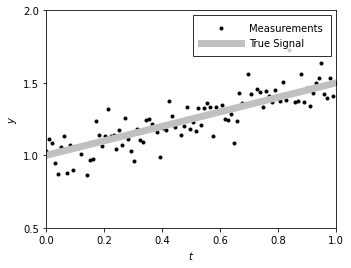

In [3]:
# Plot the generated data
plt.figure()
plt.plot(X, Y, 'k.', label='Measurements')
plt.plot(X, Y_tr, color='silver', linewidth=7, label="True Signal")
plt.xlabel('$t$'); plt.ylabel('$y$')
plt.xlim(0, 1); plt.ylim(0.5, 2)
plt.yticks(jnp.arange(0.5, 2.1, 0.5))
plt.gca().set_aspect(0.5)
plt.legend(loc=1, borderpad=0.8, handlelength=4, fancybox=False, edgecolor='k');
plt.show()

Now we apply the batch solution, given by equation (3.4):
\begin{align*}
    \textbf{m}_T &= \left[ \textbf{P}_0^{-1} + \frac{1}{\sigma^2} \textbf{H}^T \textbf{H} \right]^{-1} \left[ \frac{1}{\sigma^2} \textbf{H}^T \textbf{y} + \textbf{P}_0^{-1} \textbf{m}_0 \right] \\
\textbf{P}_T &= \left[ \textbf{P}_0^{-1} + \frac{1}{\sigma^2} \textbf{H}^T \textbf{H} \right]^{-1}
\end{align*}
where our we arbitrarily set our prior distribution to:
\begin{align*}
    p(\theta) &= \mathcal{N}(\theta \mid \textbf{m}_0, \textbf{P}_0) = \mathcal{N}(\theta \mid (0, 0)^T, \mathcal{I})
\end{align*}

In [4]:
# Parameter update model
def update_params(m_prior, P_prior, X, Y, meas_var):
    H = jnp.vstack(([1, x[0]] for x in X))
    P_post = jnp.linalg.inv(jnp.linalg.inv(P_0) + H.T @ H / meas_var)
    m_post = P_post @ (H.T @ Y / meas_var + jnp.linalg.inv(P_0) @ m_0)
    return m_post, P_post 

In [5]:
# Prior parameters
m_0 = jnp.array([0,0], dtype=jnp.float32).reshape(2,-1)
P_0 = jnp.eye(2)

# Posterior parameters
m_T, P_T = update_params(m_0, P_0, X, Y, var)

print('True theta value = ', theta)
print('Posterior theta mean = ', m_T)

True theta value =  [1.  0.5]
Posterior theta mean =  [[0.979979  ]
 [0.53430796]]


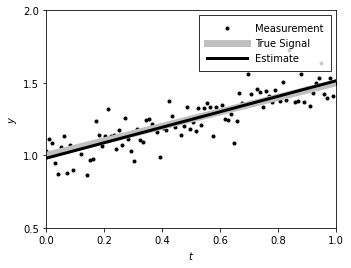

In [6]:
# Posterior estimation
Y_post = m_T[1] * X + m_T[0]

# Plot the generated data
plt.figure()
plt.plot(X, Y, 'k.', label='Measurement')
plt.plot(X, Y_tr, color='silver', linewidth=7, label="True Signal")
plt.plot(X, Y_post, color='k', linewidth=3, label="Estimate")
plt.xlabel('$t$'); plt.ylabel('$y$')
plt.xlim(0, 1); plt.ylim(0.5, 2)
plt.yticks(jnp.arange(0.5, 2.1, 0.5))
plt.gca().set_aspect(0.5)
plt.legend(loc=1, borderpad=0.8, handlelength=4, fancybox=False, edgecolor='k');
plt.show()

## 3.2 Recursive Linear Regression

We use equation (3.7) to replicate Figures 3.3 and 3.4.

In [7]:
def recursive_lin_reg(m_0, P_0, obs_var, X, Y):
    def _step(carry, t):
        m_k, P_k = carry
        H_k = jnp.array([[1, X[t,0]]])

        # Compute params after single update
        P_post = jnp.linalg.inv(jnp.linalg.inv(P_k) + H_k.T @ H_k / obs_var)
        m_post = P_post @ (H_k.T * Y[t] / obs_var + jnp.linalg.inv(P_k) @ m_k)

        return (m_post, P_post), (m_post, P_post)

    num_timesteps = len(Y)
    carry = (m_0, P_0)
    _, (ms, Ps) = lax.scan(
        _step, carry, jnp.arange(num_timesteps)
    )
    return ms, Ps

# Run recursive linear regression
ms, Ps = recursive_lin_reg(m_0, P_0, var, X, Y)

First, we replicate Figure 3.3.

In [8]:
# Batch mean result
theta1_bmean = jnp.ones(X.shape) * m_T[0]
theta2_bmean = jnp.ones(X.shape) * m_T[1]

# Recursive mean results
theta1_rmean = ms[:,0]
theta2_rmean = ms[:,1]

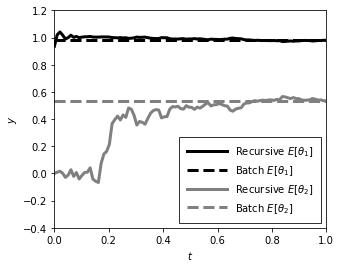

In [9]:
# Plot the generated data
plt.figure()
plt.plot(X, theta1_rmean, 'k', linewidth=3, label=r"Recursive $E[\theta_1]$")
plt.plot(X, theta1_bmean, 'k--', linewidth=3, label=r"Batch $E[\theta_1]$")
plt.plot(X, theta2_rmean, color='gray', linewidth=3, label=r"Recursive $E[\theta_2]$")
plt.plot(X, theta2_bmean, '--', color='gray', linewidth=3, label=r"Batch $E[\theta_2]$")
plt.xlabel('$t$'); plt.ylabel('$y$')
plt.xlim(0, 1); plt.ylim(-0.4, 1.2)
plt.yticks(jnp.arange(-0.4, 1.3, 0.2))
plt.gca().set_aspect(0.5)
plt.legend(loc=4, borderpad=0.8, handlelength=4, fancybox=False, edgecolor='k');
plt.show()

Next, we replicate Figure 3.4.

In [10]:
# Batch var result
theta1_bvar = jnp.ones(X.shape) * P_T[0,0]
theta2_bvar = jnp.ones(X.shape) * P_T[1,1]

# Recursive var results
theta1_rvar = Ps[:,0,0]
theta2_rvar = Ps[:,1,1]

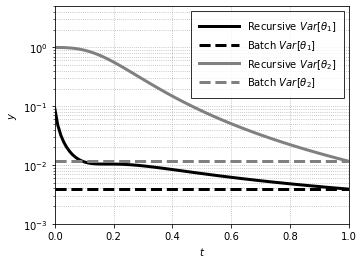

In [11]:
# Plot the generated data
plt.figure()
plt.plot(X, theta1_rvar, 'k', linewidth=3, label=r"Recursive $Var[\theta_1]$")
plt.plot(X, theta1_bvar, 'k--', linewidth=3, label=r"Batch $Var[\theta_1]$")
plt.plot(X, theta2_rvar, color='gray', linewidth=3, label=r"Recursive $Var[\theta_2]$")
plt.plot(X, theta2_bvar, '--', color='gray', linewidth=3, label=r"Batch $Var[\theta_2]$")
plt.xlabel('$t$'); plt.ylabel('$y$')
plt.yscale("log")
plt.xlim(0, 1); plt.ylim(1e-3, 5)
plt.gca().set_aspect(0.2)
plt.legend(loc=1, borderpad=0.8, handlelength=4, fancybox=False, edgecolor='k');
plt.grid(True, which="both", ls=':')

## 3.4 Drift Model for Linear Regression

First, we generate some sinusoidal signal dataset.

In [115]:
# Generate grid
X = jnp.linspace(0.0, 2.0, 200).reshape(-1,1)

# Define linear regression model
def sin_model(key, x, var):
    epsilon = jr.normal(key)*var
    return jnp.sin(jnp.pi * x) + epsilon
sin_model_vmap = jax.vmap(sin_model, in_axes=(0, 0, None), out_axes=0)

# True signal
Y_tr = jnp.sin(jnp.pi * X)

# Generate dataset (var = 0.2)
var = 0.2
keys = jr.split(jr.PRNGKey(42), X.shape[0])
Y = sin_model_vmap(keys, X, var)

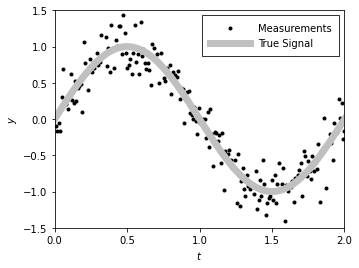

In [116]:
# Plot the generated data
plt.figure()
plt.plot(X, Y, 'k.', label='Measurements')
plt.plot(X, Y_tr, color='silver', linewidth=7, label="True Signal")
plt.xlabel('$t$'); plt.ylabel('$y$')
plt.xlim(0, 2); plt.ylim(-1.5, 1.5)
plt.xticks(jnp.arange(0, 2.1, 0.5))
plt.yticks(jnp.arange(-1.5, 1.6, 0.5))
plt.gca().set_aspect(0.5)
plt.legend(loc=1, borderpad=0.8, handlelength=4, fancybox=False, edgecolor='k');
plt.show()

Next, we use equation (3.10) to compute the filtered estimate.

In [124]:
# Random walk filter
def random_walk_filter(m_0, P_0, Q, obs_var, X, Y):
    def _step(carry, t):
        m_k, P_k = carry
        H_k = jnp.array([[1, X[t,0]]])

        # Predict using Chapman-Kolmogorov
        m_pred = m_k
        P_pred = P_k + Q

        # Update on single observation
        S = H_k @ P_pred @ H_k.T + obs_var
        K = P_pred @ H_k.T / S
        m_post = m_pred + K * (Y[t] - H_k @ m_pred)
        P_post = P_pred - K @ K.T * S

        return (m_post, P_post), (m_post, P_post)

    num_timesteps = len(Y)
    carry = (m_0, P_0)
    _, (ms, Ps) = lax.scan(
        _step, carry, jnp.arange(num_timesteps)
    )
    return ms, Ps

# Prior parameters
m_0 = jnp.array([0,0], dtype=jnp.float32).reshape(2,-1)
P_0 = jnp.eye(2)
Q = jnp.eye(2) * 0.01

# Run recursive linear regression
ms, Ps = random_walk_filter(m_0, P_0, Q, var, X, Y)

# Compute estimate values
Y_est = ms[:,1] * X + ms[:,0]

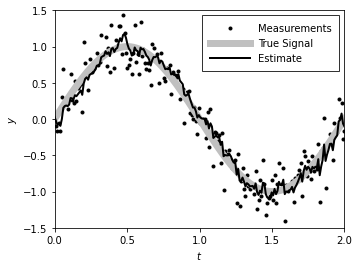

In [125]:
# Plot the generated data
plt.figure()
plt.plot(X, Y, 'k.', label='Measurements')
plt.plot(X, Y_tr, color='silver', linewidth=7, label="True Signal")
plt.plot(X, Y_est, 'k-', linewidth=2, label="Estimate")
plt.xlabel('$t$'); plt.ylabel('$y$')
plt.xlim(0, 2); plt.ylim(-1.5, 1.5)
plt.xticks(jnp.arange(0, 2.1, 0.5))
plt.yticks(jnp.arange(-1.5, 1.6, 0.5))
plt.gca().set_aspect(0.5)
plt.legend(loc=1, borderpad=0.8, handlelength=4, fancybox=False, edgecolor='k');
plt.show()

## 3.5 State Space model for Linear Regression with Drift

We can also use a Kalman filter to replicate the random walk filter result from above (and Figure 3.6).

In [128]:
# Kalman filter assuming constant transition and measurement models
def kalman_filter(m_0, P_0, H, R, A, Q, Y):
    def _step(carry, t):
        m_k, P_k = carry

        # Prediction step
        m_pred = A @ m_k
        P_pred = A @ P_k @ A.T + Q

        # Update step
        S = H @ P_pred @ H.T + R
        K = P_pred @ H.T @ jnp.linalg.inv(S)
        m_post = m_pred + K * (Y[t] - H @ m_pred)
        P_post = P_pred - K @ S @ K.T

        return (m_post, P_post), (m_post, P_post)

    num_timesteps = len(Y)
    carry = (m_0, P_0)
    _, (ms, Ps) = lax.scan(
        _step, carry, jnp.arange(num_timesteps)
    )
    return ms, Ps

# Prior parameters
m_0 = jnp.array([0,0], dtype=jnp.float32).reshape(2,-1)
P_0 = jnp.eye(2)
H = jnp.array([[1, 0]])
Q = jnp.eye(2) * 0.01
A = jnp.array([[1, (X[1]-X[0])[0]],
               [0, 1]])

# Run Kalman filter
ms, Ps = kalman_filter(m_0, P_0, H, var, A, Q, Y)

# Compute estimate values
Y_est = ms[:,0]

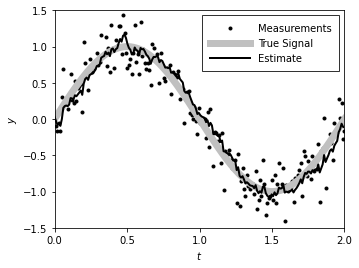

In [129]:
# Plot the generated data
plt.figure()
plt.plot(X, Y, 'k.', label='Measurements')
plt.plot(X, Y_tr, color='silver', linewidth=7, label="True Signal")
plt.plot(X, Y_est, 'k-', linewidth=2, label="Estimate")
plt.xlabel('$t$'); plt.ylabel('$y$')
plt.xlim(0, 2); plt.ylim(-1.5, 1.5)
plt.xticks(jnp.arange(0, 2.1, 0.5))
plt.yticks(jnp.arange(-1.5, 1.6, 0.5))
plt.gca().set_aspect(0.5)
plt.legend(loc=1, borderpad=0.8, handlelength=4, fancybox=False, edgecolor='k');
plt.show()

Even though the chapter does not cover RTS smoothers, I will implement one to replicate Figure 3.7 for completeness.

In [130]:
def rts_smoother(m_0, P_0, H, R, A, Q, Y):
    def _step(carry, t):
        m_k, P_k = carry
        m_kf, P_kf = m_kfs[t], P_kfs[t]

        # Prediction step
        m_pred = A @ m_kf
        P_pred = A @ P_kf @ A.T + Q

        # Update step
        G = P_kf @ A.T @ jnp.linalg.inv(P_pred)
        m_smoothed = m_kf + G @ (m_k - m_pred)
        P_smoothed = P_kf + G @ (P_k - P_pred) @ G.T

        return (m_smoothed, P_smoothed), (m_smoothed, P_smoothed)

    # Run through kalman filter and reverse
    m_kfs, P_kfs = kalman_filter(m_0, P_0, H, R, A, Q, Y)
    m_kfs, P_kfs = m_kfs[::-1], P_kfs[::-1]

    m_start, P_start = m_kfs[0], P_kfs[0]
    carry = (m_start, P_start)
    _, (m_rts, P_rts) = lax.scan(
        _step, carry, jnp.arange(1, len(m_kfs))
    )
    # Append smoothed (= filtered) value for final timestep
    m_rts = jnp.append(m_rts[::-1], jnp.expand_dims(m_start, 0), 0)
    P_rts = jnp.append(P_rts[::-1], jnp.expand_dims(P_start, 0), 0)
    return m_rts, P_rts

# Prior parameters
m_0 = jnp.array([0,0], dtype=jnp.float32).reshape(2,-1)
P_0 = jnp.eye(2)
H = jnp.array([[1, 0]])
Q = jnp.eye(2) * 0.005
A = jnp.array([[1, (X[1]-X[0])[0]],
               [0, 1]])

# Run RTS smoother
ms, Ps = rts_smoother(m_0, P_0, H, var, A, Q, Y)

# Compute estimate values
Y_est = ms[:,0]

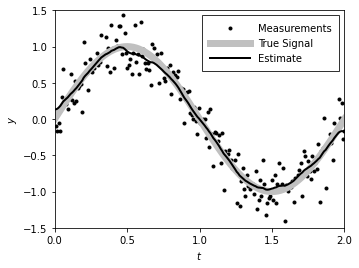

In [131]:
# Plot the generated data
plt.figure()
plt.plot(X, Y, 'k.', label='Measurements')
plt.plot(X, Y_tr, color='silver', linewidth=7, label="True Signal")
plt.plot(X, Y_est, 'k-', linewidth=2, label="Estimate")
plt.xlabel('$t$'); plt.ylabel('$y$')
plt.xlim(0, 2); plt.ylim(-1.5, 1.5)
plt.xticks(jnp.arange(0, 2.1, 0.5))
plt.yticks(jnp.arange(-1.5, 1.6, 0.5))
plt.gca().set_aspect(0.5)
plt.legend(loc=1, borderpad=0.8, handlelength=4, fancybox=False, edgecolor='k');
plt.show()